In [ ]:
## Notebook env: farnaz_spatial (R kernel)
## this notebook deconvolutes spots in visium data using the mBAT reference scRNAseq data
## to get proportion of cell types present in each spot in visium slide

In [1]:
library(BayesPrism)
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpubr)

Loading required package: snowfall

Loading required package: snow

Loading required package: NMF

Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 55/56

  To enable shared memory capabilities, try: install.extras('
NMF
')

Warning message:
“replacing previous import ‘gplots::lowess’ by ‘stats::lowess’ when loading ‘BayesPrism’”
Warning message:
“replacing previous import ‘BiocParallel::register’ by ‘NMF::register’ when loading ‘BayesPrism’”
Attaching SeuratObject


Attaching package: ‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setd

In [2]:
save_name = 'mBAT_slice_A1'

In [3]:
mBAT <- readRDS("/home/ssobti/projects/farnaz_spatial/data/seurat_mBAT.rds")

In [4]:
mBAT@assays$RNA@counts -> sc_ref_mtx
t(sc_ref_mtx) -> sc_ref_mtx

In [5]:
cell.type.labels <- as.character(mBAT@meta.data$cluster_id)
cell.state.labels <- as.character(mBAT@meta.data$cluster_id)

In [6]:
spatial_seurat_obj <- Load10X_Spatial(
  "/home/ssobti/projects/farnaz_spatial/data/count-A1/outs",
  filename = "filtered_feature_bc_matrix.h5",
  assay = "Spatial",
  slice = "A1_slice",
  filter.matrix = TRUE,
  to.upper = FALSE,
  image = NULL,
)

spatial_seurat_obj@assays$Spatial@counts -> spatial_count_mtx
t(spatial_count_mtx) -> spatial_count_mtx

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from a1_slice_ to a1slice_”


In [7]:
as.matrix(sc_ref_mtx) -> sc_ref_mtx

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 13.9 GiB”


In [8]:
as.matrix(spatial_count_mtx) -> spatial_count_mtx

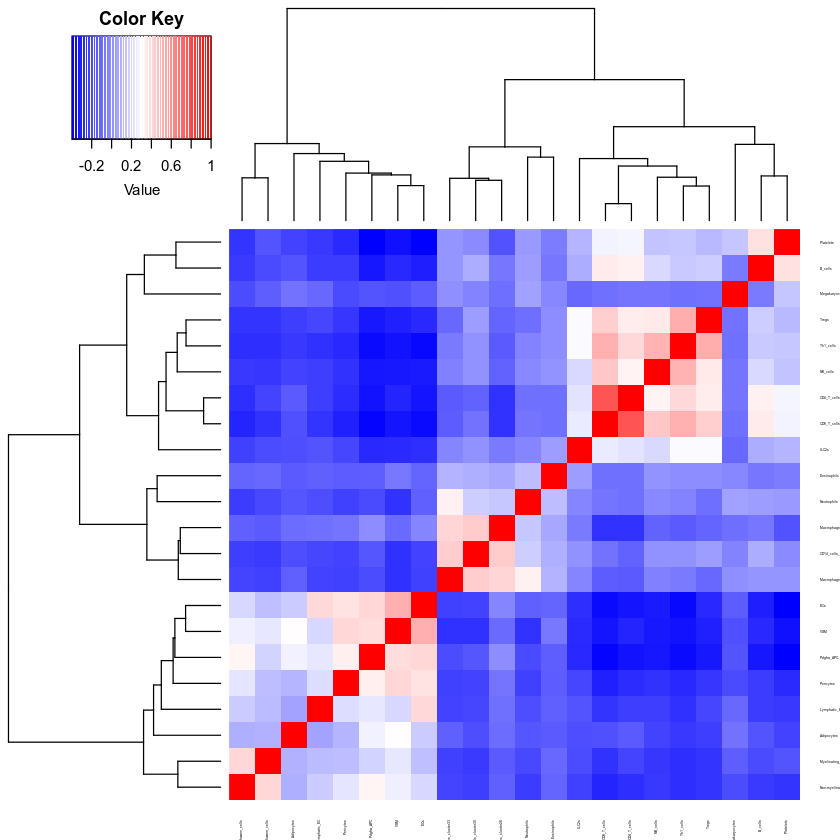

In [10]:
plot.cor.phi (input=sc_ref_mtx,
                         input.labels=cell.state.labels,
                         title="cell state correlation",
                         #specify pdf.prefix if need to output to pdf
                         #pdf.prefix="gbm.cor.cs", 
                         cexRow=0.2, cexCol=0.2,
                         margins=c(2,2))

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


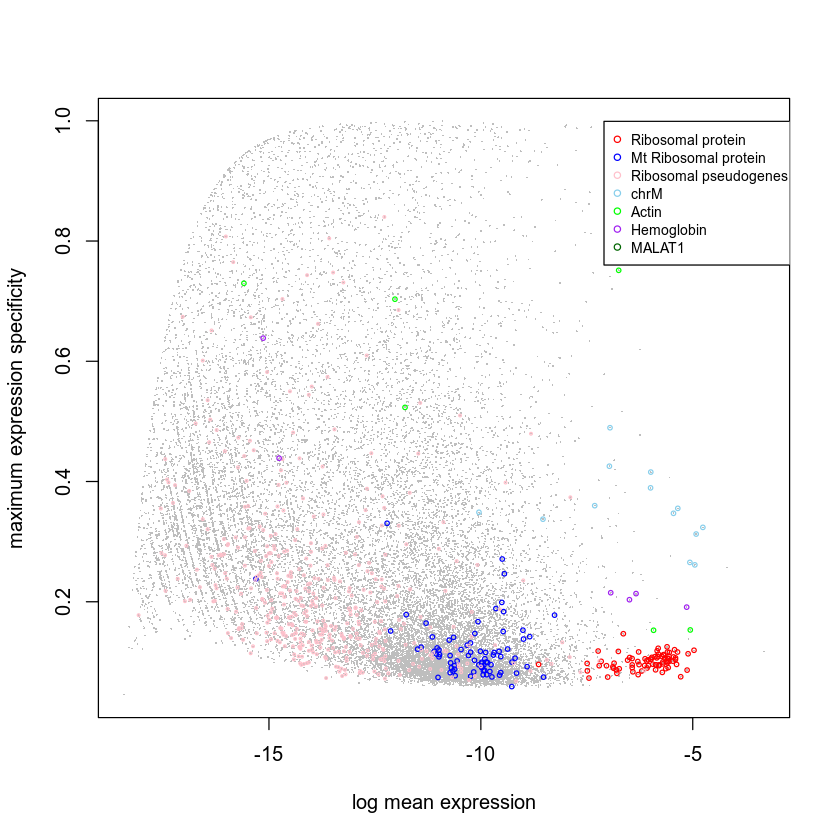

In [11]:
sc.stat <- plot.scRNA.outlier(
  input=sc_ref_mtx, #make sure the colnames are gene symbol or ENSMEBL ID 
  cell.type.labels=cell.type.labels,
  species="mm", #currently only human(hs) and mouse(mm) annotations are supported
  return.raw=TRUE #return the data used for plotting. 
  #pdf.prefix="gbm.sc.stat" specify pdf.prefix if need to output to pdf
)

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


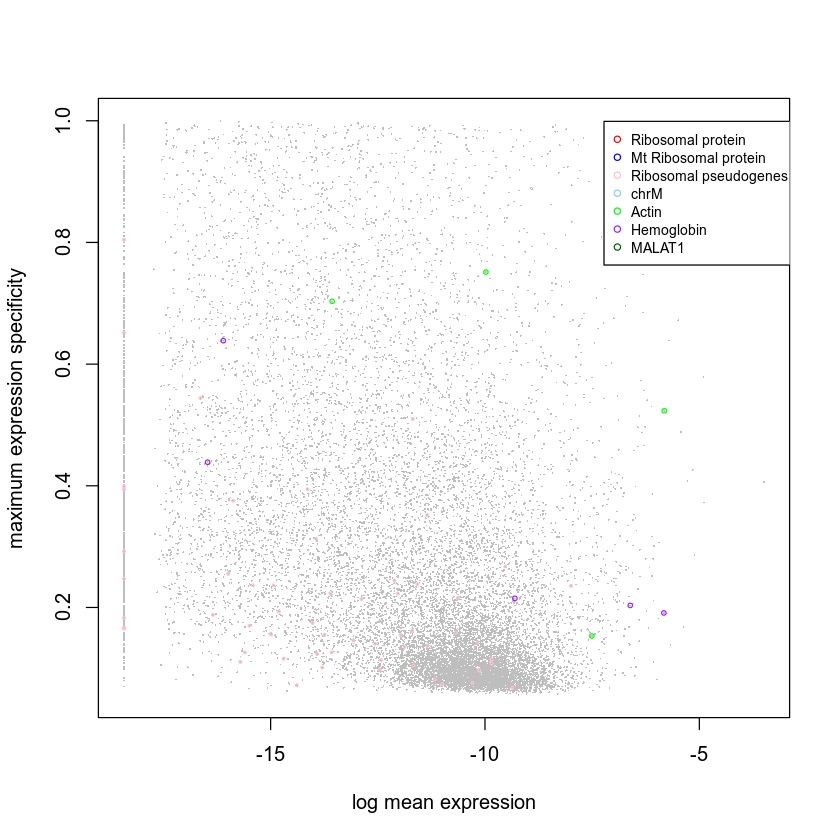

In [12]:
spatial.stat <- plot.bulk.outlier(
  bulk.input=spatial_count_mtx,#make sure the colnames are gene symbol or ENSMEBL ID 
    sc.input=sc_ref_mtx, #make sure the colnames are gene symbol or ENSMEBL ID 
  cell.type.labels=cell.type.labels,
  species="mm", #currently only human(hs) and mouse(mm) annotations are supported
  return.raw=TRUE
  #pdf.prefix="gbm.bk.stat" specify pdf.prefix if need to output to pdf
)

In [9]:
gene.list <- read.table(system.file("extdata", "genelist.mm.new.txt", package="BayesPrism"),sep="\t",header=F,stringsAsFactors=F)

In [14]:
genes_to_throw = gene.list$V3[gene.list$V1 %in% c("Rb","Mrp","other_Rb","chrM","MALAT1","chrX","chrY")]

In [13]:
## filter out genes
sc.ref.filtered = sc_ref_mtx[, !(colnames(sc_ref_mtx) %in% genes_to_throw)]
cell_counts_above_zero <- apply(X = sc.ref.filtered, MARGIN = 2, FUN = function(x){length(which(x>0))})
sc.ref.filtered = sc.ref.filtered[, cell_counts_above_zero > 4]

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes filtered in each category: 
      Rb      Mrp other_Rb     chrM   MALAT1     chrX     chrY 
       0        0        0        0        0        2        0 
A total of  2  genes from Rb Mrp other_Rb chrM MALAT1 chrX chrY  have been excluded 
A total of  56  gene expressed in fewer than  5  cells have been excluded 


In [5]:
library(org.Mm.eg.db)
library(AnnotationDbi)

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:NMF’:

    nrun


The following object is masked from ‘package:pkgmaker’:

    new2


The following objects are masked from ‘package:base’:

    expand.grid, I, unname






In [15]:
gene_type_annotations <- mapIds(org.Mm.eg.db, keys = colnames(sc.ref.filtered),
       column = "GENETYPE", keytype = "SYMBOL")



'select()' returned 1:1 mapping between keys and columns



In [16]:
unique(gene_type_annotations)

[1] "protein-coding" NA               "ncRNA"          "unknown"       
[5] "other"          "pseudo"

In [17]:
gene_type_df = data.frame(genes = names(gene_type_annotations), gene_type = as.character(gene_type_annotations))

In [18]:
gene_type_df <- gene_type_df[gene_type_df$gene_type %in% c('protein-coding', 'ncRNA', 'pseudo'),]

In [19]:
head(gene_type_df)

,genes,gene_type
,<chr>,<chr>
1,Xkr4,protein-coding
2,Gm1992,protein-coding
3,Rp1,protein-coding
4,Sox17,protein-coding
5,Mrpl15,protein-coding
6,Lypla1,protein-coding


In [20]:
protein_coding_genes = (gene_type_df %>% filter(gene_type == 'protein-coding'))$genes
ncRNA_genes = (gene_type_df %>% filter(gene_type == 'ncRNA'))$genes
pseudo_genes = (gene_type_df %>% filter(gene_type == 'pseudo'))$genes

In [21]:
sc_total_exp = colSums(sc.ref.filtered)
spatial_total_exp = colSums(spatial_count_mtx)

In [22]:
gene_sets = list(protein_coding_genes, ncRNA_genes, pseudo_genes)
names(gene_sets) <- c('protein_coding_genes', 'ncRNA_genes', 'pseudo_genes')

In [23]:
names(gene_sets)

[1] "protein_coding_genes" "ncRNA_genes"          "pseudo_genes"

In [24]:
grphs = list()

for (i in 1:3){
    sc_ref <- sc_total_exp[gene_sets[[i]]]
    spatial_bulk <- spatial_total_exp[gene_sets[[i]]]
    sc_ref <- log2(sc_ref)
    spatial_bulk <- log2(spatial_bulk)
    graphing_df = data.frame(log2sc_ref = sc_ref, log2spatial_bulk = spatial_bulk)
    grphs[[i]] = ggplot(graphing_df, aes(log2sc_ref, log2spatial_bulk)) + geom_point() + geom_abline(slope = 1, color = 'red', linewidth = 1.5, linetype="dashed") + theme_classic() + ggtitle(names(gene_sets)[i])
}


Warning message:
“Removed 924 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1707 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 79 rows containing missing values (`geom_point()`).”


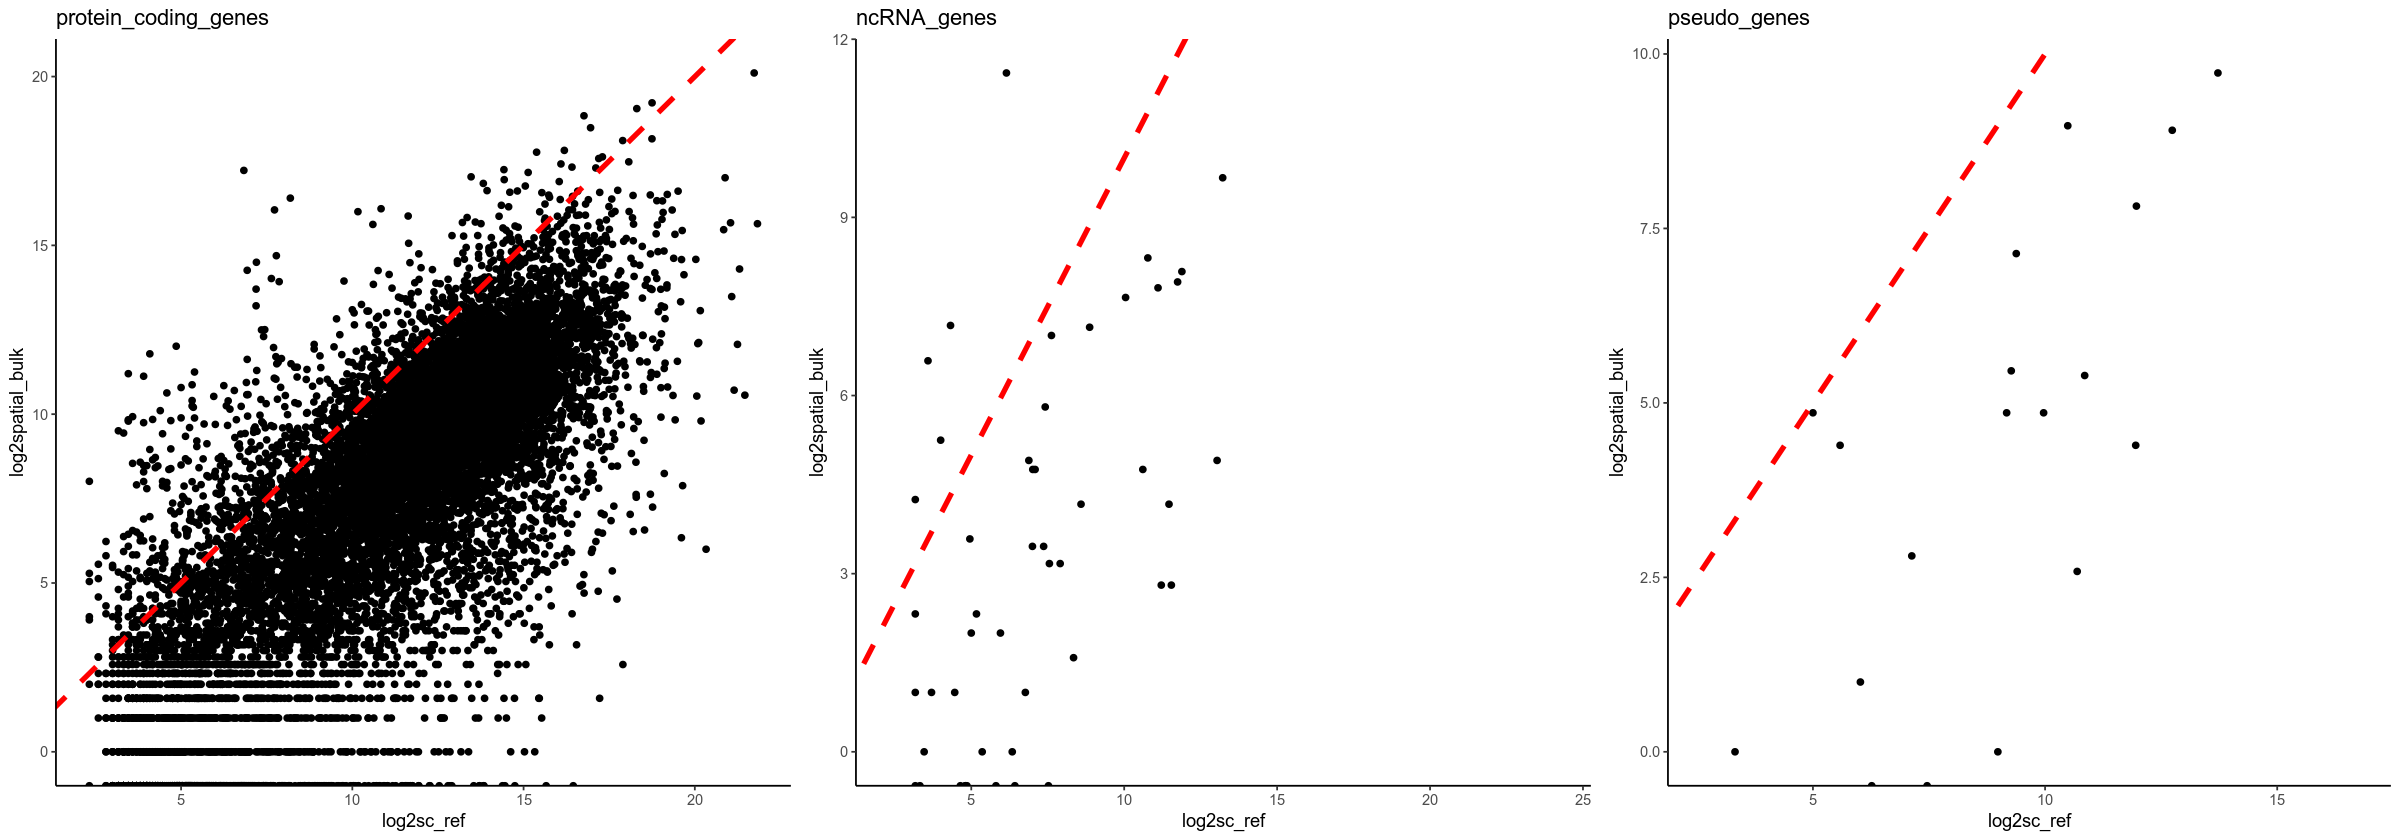

In [25]:
options(repr.plot.width=20)
ggarrange(plotlist = grphs, nrow = 1)

In [26]:
sc.ref.filtered.pc <-  sc.ref.filtered[,protein_coding_genes]

In [27]:
dim(sc.ref.filtered)

[1] 94113 19713

In [28]:
dim(sc.ref.filtered.pc)

[1] 94113 15701

In [30]:
diff.exp.stat <- get.exp.stat(sc.dat=sc_ref_mtx[,colSums(sc_ref_mtx>0)>3],# filter genes to reduce memory use
                                          cell.type.labels=cell.type.labels,
                                          cell.state.labels=cell.state.labels,
                                          psuedo.count=0.1, #a numeric value used for log2 transformation. =0.1 for 10x data, =10 for smart-seq. Default=0.1.
                                          cell.count.cutoff=50, # a numeric value to exclude cell state with number of cells fewer than this value for t test. Default=50.
                                          n.cores=1 #number of threads
                                          )

In [31]:
sc.ref.filtered.pc.sig <- select.marker (sc.dat=sc.ref.filtered.pc,
                                                  stat=diff.exp.stat,
                                                  pval.max=0.01,
                                                  lfc.min=0.1)
#> number of markers selected for each cell type: 
#> tumor :  8686 
#> myeloid :  575 
#> pericyte :  114 
#> endothelial :  244 
#> tcell :  123 
#> oligo :  86

number of markers selected for each cell type: 
CD14_cells_cluster30 :  208 
B_cells :  106 
Th1_cells :  45 
Macrophages_cluster28 :  86 
VSM :  835 
NK_cells :  115 
ECs :  420 
Pericytes :  414 
CD8_T_cells :  74 
CD4_T_cells :  32 
Tregs :  234 
Neutrophils :  232 
Macrophages_cluster33 :  353 
Lymphatic_EC :  489 
Pdgfra_APC :  512 
Non-myelinating_Schwann_cells :  386 
Myelinating_Schwann_cells :  315 
ILC2s :  90 
Platelets :  0 
Eosinophils :  196 
Adipocytes :  1080 
Megakaryocytes :  320 


In [32]:
dim(sc.ref.filtered.pc.sig)

[1] 94113  6128

In [ ]:
myPrism <- new.prism(
  reference=sc.ref.filtered.pc, 
  mixture=spatial_count_mtx,
  input.type="count.matrix", 
  cell.type.labels = cell.type.labels, 
  cell.state.labels = cell.state.labels,
  key=NULL,
  outlier.cut=0.01,
    outlier.fraction=0.1,
)
#> number of cells in each cell state 
#> cell.state.labels
#> PJ017-tumor-6 PJ032-tumor-5     myeloid_8 PJ032-tumor-4 PJ032-tumor-3 PJ017-tumor-5         tcell PJ032-tumor-2 PJ030-tumor-5     myeloid_7 PJ035-tumor-8 PJ017-tumor-4 PJ017-tumor-3 PJ017-tumor-2 PJ017-tumor-0 PJ017-tumor-1 PJ018-tumor-5     myeloid_6     myeloid_5 PJ035-tumor-7         oligo PJ048-tumor-8 PJ032-tumor-1 PJ032-tumor-0 PJ048-tumor-7 PJ025-tumor-9 PJ035-tumor-6 PJ048-tumor-6 PJ016-tumor-6 PJ018-tumor-4     myeloid_4 PJ048-tumor-5 PJ048-tumor-4 PJ016-tumor-5 PJ025-tumor-8 PJ048-tumor-3 PJ035-tumor-5 PJ030-tumor-4 PJ018-tumor-3 PJ016-tumor-4 PJ025-tumor-7     myeloid_3 PJ035-tumor-4     myeloid_2 PJ025-tumor-6 PJ018-tumor-2 PJ030-tumor-3 PJ016-tumor-3 PJ025-tumor-5 PJ030-tumor-2 PJ018-tumor-1 PJ035-tumor-3 PJ048-tumor-2 PJ018-tumor-0 PJ048-tumor-1 PJ035-tumor-2 PJ035-tumor-1 PJ016-tumor-2 PJ030-tumor-1      pericyte   endothelial PJ035-tumor-0 PJ025-tumor-4     myeloid_1 PJ048-tumor-0     myeloid_0 PJ030-tumor-0 PJ025-tumor-3 PJ016-tumor-1 PJ016-tumor-0 PJ025-tumor-2 PJ025-tumor-1 PJ025-tumor-0 
#>            22            41            49            57            62            64            67            72            73            75            81            83            89           101           107           107           113           130           141           150           160           169           171           195           228           236           241           244           261           262           266           277           303           308           319           333           334           348           361           375           381           382           385           386           397           403           419           420           421           425           429           435           437           444           463           471           474           481           482           489           492           512           523           526           545           550           563           601           619           621           630           941           971 
#> Number of outlier genes filtered from mixture = 6 
#> Aligning reference and mixture... 
#> Nornalizing reference...

#Note that outlier.cut and outlier.fraction=0.1 filter genes in X whose expression fraction is greater than outlier.cut (Default=0.01) in more than outlier.fraction (Default=0.1) of bulk data. 
#Typically for dataset with reasonable quality control, very few genes will be filtered. 
#Removal of outlier genes will ensure that the inference will not be dominated by outliers, which sometimes may be resulted from poor QC in mapping.

In [ ]:
bp.res <- run.prism(prism = myPrism, n.cores=5)

In [ ]:
path = paste0('/home/ssobti/projects/farnaz_spatial/output_data/bayesprism/', save_name)
saveRDS(object = bp.res, file = path)

In [ ]:
# extract posterior mean of cell type fraction theta
theta <- get.fraction (bp=bp.res,
            which.theta="final",
            state.or.type="type")

head(theta)

In [ ]:
theta.cv <- bp.res@posterior.theta_f@theta.cv

head(theta.cv)